In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates
import seaborn as sns

from scipy.stats import skew
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sktime.forecasting.naive import NaiveForecaster

<p style="font-size:2em; font-weight:400; margin:.2em 0;">Case/Challenge</p>

**Objective**  
In this task, your goal is to perform exploratory data analysis (EDA) on a given dataset and extract meaningful insights. Additionally, using those insights, we would like you to build a forecasting model to either forecast the revenue or the volume of customer support cases for any timeframe (e.g., next quarter, next year).

**Dataset Overview**  
You have been provided with a dataset (zip file) that contains information about:  
- Customer cases  
- Customer information  
- Customer products  
- Product details  

Each file has specific fields that describe various aspects of the business. A data dictionary is also provided within the files.

**Tasks**  

*Exploratory Data Analysis (EDA):*  
- Analyze customer cases, information, and product data.  
- Present relevant findings and as many patterns as you can find.  
- Describe any interesting cases where the finding was unintuitive initially.  
- Remember: Data Science is all about experimenting with data, not only about building models.  

*Forecasting:*
- Build a forecasting model to extrapolate revenue for the first three months of next year.  

**Timebox**  
It should not take more than half a working day; please do not spend more than 8 hours on it.


<p style="font-size:2em; font-weight:400; margin:.2em 0;">Structure</p>

In this notebook, I project revenue for a subscription-based business using data from 2017–2021 by forecasting adds & churns. After conducting exploratory data analysis (EDA), I segment the customer base and forecast both the number of new subscriptions (adds) and the churn rate. These forecasts are combined with the customer base at the end of 2021 and the product price to project revenue for the first quarter of 2022. The forecast suggests solid revenue growth in early 2022.

Given the time constraints, I made simplifying assumptions and did not fully explore all alternative modelling approaches.

**Table of Contents**

1. Data Inspection
2. Modelling
3. Revenue Projection

# Data Inspection

## Cases

In [2]:
df_case = pd.read_csv('customer_cases.csv')

In [3]:
df_case.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330512 entries, 0 to 330511
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   330512 non-null  int64 
 1   case_id      330512 non-null  object
 2   date_time    330512 non-null  object
 3   customer_id  330512 non-null  object
 4   channel      330512 non-null  object
 5   reason       330512 non-null  object
dtypes: int64(1), object(5)
memory usage: 15.1+ MB


There are no missing values in the Cases dataset. The column "Unnamed: 0" is not in the dictionary, it likely is an artefact from pd.to_csv(). I will drop it and convert the date_time

In [4]:
df_case.head(1)

,Unnamed: 0,case_id,date_time,customer_id,channel,reason
0,1,CC101,2017-01-01 10:32:03,C2448,phone,signup


In [5]:
df_case.drop(columns = 'Unnamed: 0',inplace = True)

In [6]:
df_case["date_time"] = pd.to_datetime(df_case["date_time"])

In [7]:
df_case.groupby('customer_id')['case_id'].nunique().describe(percentiles = [.5,.75,.9,.95])

count   258,660.00
mean          1.28
std           0.51
min           1.00
50%           1.00
75%           1.00
90%           2.00
95%           2.00
max           5.00
Name: case_id, dtype: float64

We see that the vast majority of the approx 260k customers creates only 2 or fewer cases. 

In [8]:
shares_ch_r = pd.crosstab(df_case['reason'], df_case['channel'], normalize='all')

In [9]:
row_totals = shares_ch_r.sum(axis=1)
col_totals = shares_ch_r.sum(axis=0)

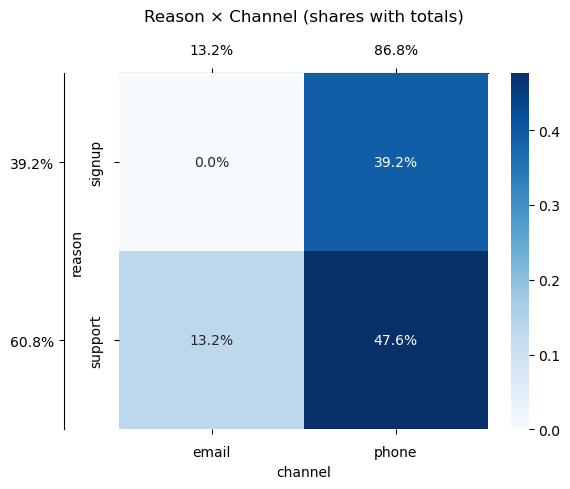

In [10]:
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(shares_ch_r, annot=True, fmt=".1%", cmap="Blues", cbar=True, ax=ax)

ax.yaxis.tick_left()
ax.tick_params(axis='y', pad=8)
ax.tick_params(axis='x', pad=8)

left_totals = ax.secondary_yaxis('left')
left_totals.set_yticks(ax.get_yticks())
left_totals.set_yticklabels(row_totals.map(lambda p: f"{p:.1%}"))

left_totals.spines['left'].set_position(('outward', 40))

top_totals = ax.secondary_xaxis('top')
top_totals.set_xticks(ax.get_xticks())
top_totals.set_xticklabels(col_totals.map(lambda p: f"{p:.1%}"))
top_totals.tick_params(axis='x', pad=8)

left_totals.set_ylabel("")
top_totals.set_xlabel("")
ax.set_title("Reason × Channel (shares with totals)", pad=16)

plt.tight_layout()
plt.show()

Around 60% of cases are related to support, more than 85% of all cases were created via phone. At a more granular level, no sign-up cases were created via email. Given the large number of observations, this looks like a structural zero (e.g. classification rules) or a glitch in the data. While I cannot completely rule out the possibility that email inquiries about sign-ups never occur, that explanation seems rather implausible.

## Customers

In [11]:
df_cust = pd.read_csv('customer_info.csv')

In [12]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508932 entries, 0 to 508931
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   508932 non-null  int64 
 1   customer_id  508932 non-null  object
 2   age          508932 non-null  int64 
 3   gender       508932 non-null  object
dtypes: int64(2), object(2)
memory usage: 15.5+ MB


Approx. 500 customers are in the data, there are no missing values.

In [13]:
df_cust.drop(columns = 'Unnamed: 0',inplace = True) # As above

In [14]:
df_cust.head(1)

,customer_id,age,gender
0,C2448,76,female


In [15]:
df_cust.gender.value_counts(normalize = True)

gender
male     0.61
female   0.39
Name: proportion, dtype: float64

The gender ratio is imbalanced, roughly 61% are male while 39% are female. Let us take a look at the age distribution for males and females:

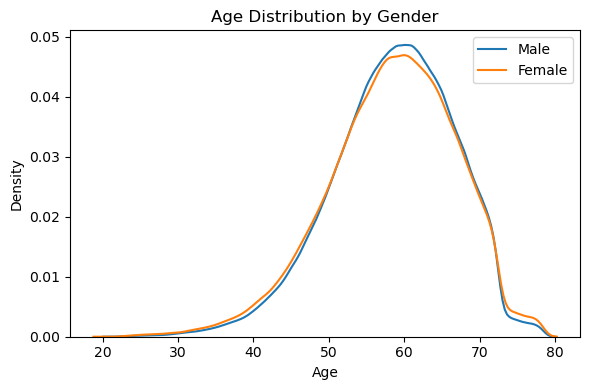

In [16]:
fig, ax = plt.subplots(figsize=(6,4))

male   = df_cust.query('gender == "male"')["age"]
female  = df_cust.query('gender == "female"')["age"]

sns.kdeplot(x=male,  ax=ax, label="Male")
sns.kdeplot(x=female, ax=ax, label="Female")
ax.set_title("Age Distribution by Gender")
ax.set_xlabel("Age")
ax.set_ylabel("Density")

ax.legend()

plt.tight_layout()
plt.show()

The male and female curves nearly overlap, indicating very similar age profiles. We therefore focus on the overall distribution.

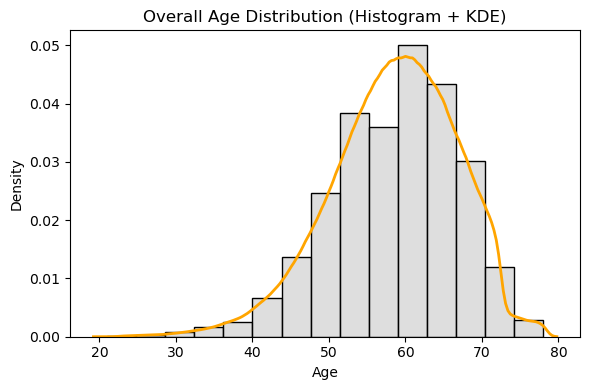

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(data=df_cust,x="age",bins = 15, stat="density",color="lightgrey",edgecolor="black",ax=ax)
sns.kdeplot(data=df_cust, x="age",ax=ax, color="orange", linewidth=2)
ax.set_title("Overall Age Distribution (Histogram + KDE)", fontsize=12)
ax.set_xlabel("Age")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

In [18]:
print(f"Mean: {df_cust.age.mean():.2f}")
print(f"Median: {df_cust.age.median():.2f}")
print(f"Skew: {skew(df_cust.age):.2f}")

Mean: 58.47
Median: 59.00
Skew: -0.47


Apart from the tails, the overall distribution appears symmetrical, with only a slight negative (left) skew, i.e. meaning the mean lies just left of the median. There is, however, a sharp drop in the right tail beyond age 70, visible for both genders, which is difficult to explain at this stage.

## Products

In [19]:
df_prod = pd.read_csv('product_info.csv')

In [20]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     2 non-null      object
 1   name           2 non-null      object
 2   price          2 non-null      int64 
 3   billing_cycle  2 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 196.0+ bytes


In [21]:
df_prod

,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


The effective price per unit of time is lower for an annual subscription, which is expected. In the following analysis, I assume the annual subscription is accounted for on a monthly basis at 100.

## Customer & Products

In [22]:
df_cust_prod = pd.read_csv('customer_product.csv')

In [23]:
df_cust_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508932 entries, 0 to 508931
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        508932 non-null  int64 
 1   customer_id       508932 non-null  object
 2   product           508932 non-null  object
 3   signup_date_time  508932 non-null  object
 4   cancel_date_time  112485 non-null  object
dtypes: int64(1), object(4)
memory usage: 19.4+ MB


In [24]:
df_cust_prod["signup_date_time"] = pd.to_datetime(df_cust_prod["signup_date_time"])
df_cust_prod["signup_date"] = df_cust_prod["signup_date_time"].dt.floor('D')
df_cust_prod["cancel_date_time"] = pd.to_datetime(df_cust_prod["cancel_date_time"])

In [25]:
df_cust_prod.drop(columns = 'Unnamed: 0',inplace = True) # As above

In [26]:
df_cust_prod['product'].value_counts(normalize = True)

product
prd_1   0.64
prd_2   0.36
Name: proportion, dtype: float64

The annual subscription (prd_1) is roughly twice as common as the monthly subscription (prd_2).

**Customers and Timestamps**

In [27]:
summary_temp = pd.DataFrame({
    "Unique Customers (Cases)": [df_case.customer_id.nunique()],
    "Unique Customers (Cust_Prod)": [df_cust_prod.customer_id.nunique()],
    "Earliest Case Date": [df_case.date_time.min()],
    "Earliest Signup": [df_cust_prod.signup_date_time.min()],
    "Latest Case Date": [df_case.date_time.max()],
    "Latest Signup": [df_cust_prod.signup_date_time.max()]
})

In [28]:
summary_temp

,Unique Customers (Cases),Unique Customers (Cust_Prod),Earliest Case Date,Earliest Signup,Latest Case Date,Latest Signup
0,258660,508932,2017-01-01 10:32:03,2017-01-01 07:55:42,2022-01-01 06:32:53,2021-12-31 19:38:21


There are ~500K customers in the customer-product dataset, about twice as many as in the customer-case dataset. That is, only half the customers have created a case. While the earliest/latest case dates and signup dates refer to different events, it seems reasonable to assume the two datasets span the same overall time period. Slightly counterintuitively, the case data ends on the morning of January 1 2022, but I will set that detail aside.

**Subscriptions and Cancellations over Time**

*Adds*

In [29]:
df_cust_prod['year_month'] = df_cust_prod['signup_date'].dt.to_period('M').dt.to_timestamp(how='start')

In [30]:
signups = df_cust_prod.groupby("year_month")["customer_id"].nunique().reset_index()
signups = signups.rename(columns={"customer_id": "n_signups"})

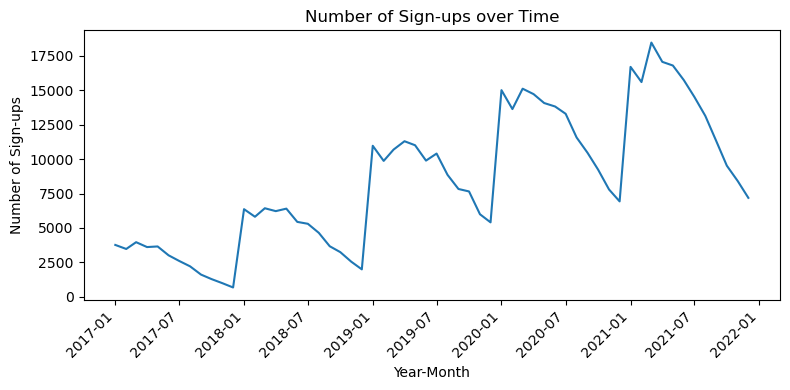

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(signups["year_month"], signups["n_signups"], color="tab:blue")

ax.set_title("Number of Sign-ups over Time")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Number of Sign-ups")

# Apply date locator & formatter
locator = mdates.MonthLocator(bymonth=[1, 7])  
formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

We observe the following:
1. A clear upward trend. The monthly number of sing-ups increase over time. 
2. A strong seasonal pattern with a jump in the beginning of the year followed by a plateau and a decline in the second half of the year.
3. The seasons seems proportional to the level. 

*Cancellations*

In [32]:
df_cust_prod.head(2)

,customer_id,product,signup_date_time,cancel_date_time,signup_date,year_month
0,C2448,prd_1,2017-01-01 10:35:09,NaT,2017-01-01,2017-01-01
1,C2449,prd_1,2017-01-01 11:39:29,2021-09-05 10:00:02,2017-01-01,2017-01-01


I interpret the missing values in the 'cancel_date_time' column as active subscriptions, meaning customers who have not churned. I assume the timestamp corresponds to the time of giving notice rather than the actual end of the subscription.

In [33]:
df_cust_prod['year_month_cancel'] = df_cust_prod['cancel_date_time'].dt.to_period('M').dt.to_timestamp(how='start')

In [34]:
cancellations = df_cust_prod.groupby("year_month_cancel")["customer_id"].nunique().reset_index()
cancellations = cancellations.rename(columns={"customer_id": "n_cancellations"})

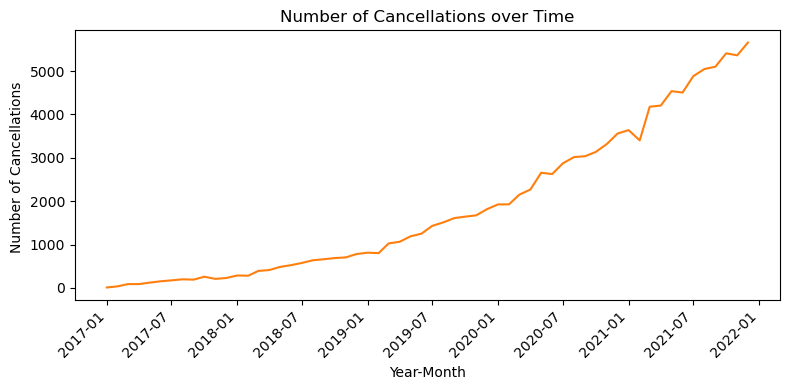

In [35]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(cancellations["year_month_cancel"], cancellations["n_cancellations"], color="tab:orange")

ax.set_title("Number of Cancellations over Time")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Number of Cancellations ")

# Apply date locator & formatter
locator = mdates.MonthLocator(bymonth=[1, 7])  # ticks at Jan and Jun
formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Clearly, cancellations increase over time, and the trend may even be exponential. This is not unexpected, as the subscriber base has also grown. Unlike sign-ups, there is no obvious seasonal pattern and the curve is smoother without recurring peaks or dips.

**Active and Churned Customers**

Let us investigate the share of active customers and look at the distribution of the customer lifetime.

In [36]:
df_cust_prod['active_cust'] = np.where(df_cust_prod['cancel_date_time'].isna(),1,0)

In [37]:
print(f"Share of active customers {round(df_cust_prod.active_cust.mean(), 2)}")

Share of active customers 0.78


In [38]:
last_obs_date = df_cust_prod['cancel_date_time'].max()

In [39]:
df_cust_prod['lifetime_days'] = np.where(
    df_cust_prod['active_cust'] == 0,
    (df_cust_prod['cancel_date_time'] - df_cust_prod['signup_date_time']).dt.days,
    (last_obs_date - df_cust_prod['signup_date_time']).dt.days,
)

This gives us the lifetime of active and churned customers as of the last observation date. 

In [40]:
df_cust_prod.groupby('active_cust')['lifetime_days'].agg(['mean', 'median']).reset_index()

,active_cust,mean,median
0,0,459.04,371.00
1,1,617.99,547.00


On average, active customers life longer.

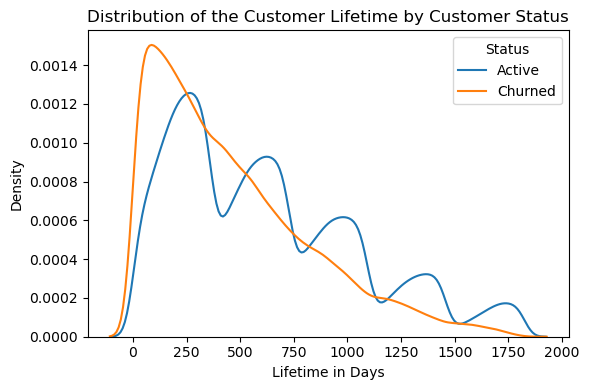

In [41]:
fig, ax = plt.subplots(figsize=(6,4))

active   = df_cust_prod.query("active_cust == 1")["lifetime_days"]
churned  = df_cust_prod.query("active_cust == 0")["lifetime_days"]

sns.kdeplot(x=active,  ax=ax, label="Active", color = 'tab:blue')
sns.kdeplot(x=churned, ax=ax, label="Churned", color = 'tab:orange')

ax.set_title("Distribution of the Customer Lifetime by Customer Status")
ax.set_xlabel("Lifetime in Days")
ax.set_ylabel("Density")
ax.legend(title="Status")
plt.tight_layout()
plt.show()

Active lifetimes show a clear annual pattern. This is a snapshot of the signup calendar: because sign-ups spike  early in the year and year-and observation and, there are lots of active customers with ages near 12, 24, 36 months, etc.

Churned lifetimes are right-skewed: many customers churn soon after subscribing, and the rest trail off in a long tail. That points to higher early-tenure risk.

# Modelling

To forecast revenue for early 2022, I project the number of new customers (adds) and churns. These forecasts are applied to the customer base as of the end of 2021 and, together with the product price, yield the revenue estimate. Implicit in this setup is the assumption that customers do not switch subscription models.

To capture different behavioral patterns, and ultimately improve forecast accuracy, I first segment the customer base using observable features. I then forecast adds and churns within each segment. I choose to aggregate the data at a monthly level. This smooths out short-term fluctuations while still preserving annual seasonality. An alternative would be to directly forecast the number of active customers (Appendix). However, modelling adds and churns separately allows the use of problem-specific models and is likely to improve performance.

I will not conduct any backtesting to evaluate the accuracy of my models. Given the strong seasonality, using the last three months of the last year as a test is unlikely to provide a robust assessment. To get a meaningful split, I would likely need to go back a full year, which may be too far from the actual forecasting period. There is also a time constraint, which prevents me from exploring alternative modelling or segmentation options in depth. Instead, the goal here is to establish a solid foundation that can serve as a benchmark for future iterations.

## Segmentation

**Dimensions**

The most intuitive segmentation dimensions are gender, age, and product. However, age is a dynamic variable, and it is unclear whether the age in the dataset reflects the customer’s age at signup or at the most recent observation. In addition, using age would require creating buckets. Given these limitations and the time constraint, I therefore exclude age from the segmentation.

In [42]:
df_prod

,product_id,name,price,billing_cycle
0,prd_1,annual_subscription,1200,12
1,prd_2,monthly_subscription,125,1


In [43]:
df_cust.gender.unique()

array(['female', 'male'], dtype=object)

We only have two products and two genders, leaving us with four segments. Let us see if take advantage of the cases dataframe and take signup inquries into account.

In [44]:
df_case[['channel','reason']].value_counts()

channel  reason 
phone    support    157313
         signup     129527
email    support     43672
Name: count, dtype: int64

In [45]:
tmp = pd.merge(df_cust_prod,df_case.query('reason == "signup"'), on = 'customer_id', how = 'inner')

In [46]:
tmp.query('date_time > signup_date_time')

,customer_id,product,signup_date_time,cancel_date_time,signup_date,year_month,year_month_cancel,active_cust,lifetime_days,case_id,date_time,channel,reason
80804,C83252,prd_1,2020-07-27 10:46:49,NaT,2020-07-27,2020-07-01,NaT,1,522.00,CC162487,2020-07-27 10:47:18,phone,signup
83418,C85866,prd_1,2020-08-23 12:25:01,NaT,2020-08-23,2020-08-01,NaT,1,495.00,CC169127,2020-08-23 12:25:03,phone,signup


In [47]:
df_signup = df_case.query('reason == "signup"').copy()

In [48]:
df_signup.customer_id.value_counts().max()

1

There are only two cases where the contact date is after the signup date and the difference is small. Perhaps a call after the signup or the data processing pipeline took a bit, each customer has at most one signup inquiry

**Segmentation DataFrame**

In [49]:
df_adds = pd.merge(df_cust_prod, df_signup, how = 'left', on = 'customer_id')

In [50]:
df_adds = pd.merge(df_adds, df_cust, how = 'left', on = 'customer_id')

In [51]:
df_adds.head(1)

,customer_id,product,signup_date_time,cancel_date_time,signup_date,year_month,year_month_cancel,active_cust,lifetime_days,case_id,date_time,channel,reason,age,gender
0,C2448,prd_1,2017-01-01 10:35:09,NaT,2017-01-01,2017-01-01,NaT,1,"1,825.00",CC101,2017-01-01 10:32:03,phone,signup,76,female


In [52]:
df_adds['pre_signup_contact'] = np.where(df_adds.reason == "signup",1,0)

In [53]:
df_seg = df_adds.groupby(['year_month','gender','product','pre_signup_contact']).agg(new_cust_count=('customer_id', 'nunique')).reset_index()

In [54]:
df_seg.sort_values(by = 'year_month',inplace = True)

In [55]:
df_seg['segment'] =  df_seg["gender"].astype(str) + "_" +df_seg["product"].astype(str) + "_" + df_seg["pre_signup_contact"].astype(str)

In [56]:
df_seg.segment.nunique()

8

As expected, we now have eight segments. In the absence of a time-constraint, I would further investigate if there is sufficient heterogeneity across segments and/or if there is still too much heterogeneity within segments. 

## Adds Forecast

**Descriptive Analysis**

In [57]:
df_temp_p = df_adds.groupby(['product','year_month']).agg(new_cust_count=('customer_id', 'nunique')).reset_index()
df_temp_g = df_adds.groupby(['gender','year_month']).agg(new_cust_count=('customer_id', 'nunique')).reset_index()
df_temp_s = df_adds.groupby(['pre_signup_contact','year_month']).agg(new_cust_count=('customer_id', 'nunique')).reset_index()

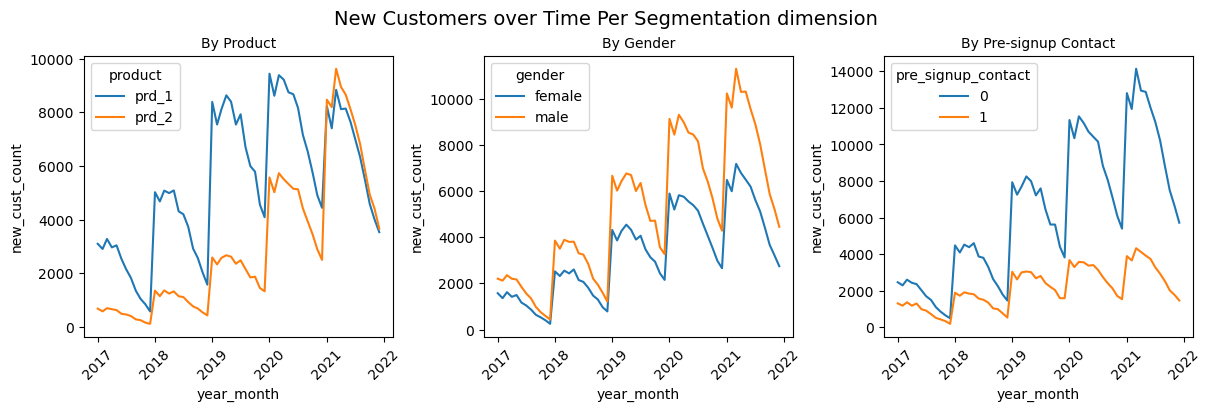

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
axes = axes.flatten()

# By product
sns.lineplot(data=df_temp_p, x="year_month", y="new_cust_count", hue="product", ax=axes[0])
axes[0].set_title("By Product", fontsize=10)
axes[0].set_xlabel("year_month")
axes[0].set_ylabel("new_cust_count")
axes[0].tick_params(axis="x", rotation=45)

# By gender
sns.lineplot(data=df_temp_g, x="year_month", y="new_cust_count", hue="gender", ax=axes[1])
axes[1].set_title("By Gender", fontsize=10)
axes[1].set_xlabel("year_month")
axes[1].set_ylabel("new_cust_count")
axes[1].tick_params(axis="x", rotation=45)

# By pre-signup contact
sns.lineplot(data=df_temp_s, x="year_month", y="new_cust_count", hue="pre_signup_contact", ax=axes[2])
axes[2].set_title("By Pre-signup Contact", fontsize=10)
axes[2].set_xlabel("year_month")
axes[2].set_ylabel("new_cust_count")
axes[2].tick_params(axis="x", rotation=45)

fig.suptitle("New Customers over Time Per Segmentation dimension", fontsize=14)
plt.show()

We see a clear annual pattern across all segments. Furthermore, growth in new customers for product 2 clearly outpaces product 1. Similarly, growth among customers without prior contact exceeds that of their counterparts. The growth pattern by gender, however, is comparable. These results in general support the segmentation strategy. One could argue there is a structural break at the beginning of 2019. Given time constraints, I won’t dig into this further.

**Forecast Model**

I use two simple models two forecast new customers. The first is a seasonal naïve forecaster, which takes the most recent value from the same month from the previous and uses that as the forecast. The second is an ETS model. Since we do not know in advance which ETS specification is most appropriate for each series, I employ a function that tests several reasonable alternatives and selects the one that minimizes an Information Criteria (AICs). Because AICc penalizes additional parameters, it balances fit and complexity, reducing the risk of overfitting. Each series gets their own S-Naive and ETS Model, i.e. we estimate different models for each segment (a combination of above segmentation dimensions).

*Helper Function*

In [59]:
def ets_model(y, n_periods): 
    ETS_parameters = []
    aicc_by_spec = {}
    valid_combinations = [ # I fix the error to be additive
        (None, False, "add"), # additional season 
        ("add", False, "add"), # additional season & trend
        ("add", True,  "add"), # additionl season & damped trend
    ]

    for trend, damped, seasonal in valid_combinations:
        model = ETSModel(endog=y, error='add', seasonal=seasonal, trend=trend, damped_trend=damped, seasonal_periods=12)
        res = model.fit()
        aicc_by_spec[(trend, damped, seasonal)] = float(res.aicc)

    best_trend, best_damped, best_seasonal = min(aicc_by_spec, key=aicc_by_spec.get)
    model = ETSModel(endog=y, error='add', seasonal=best_seasonal, trend=best_trend, damped_trend=best_damped, seasonal_periods=12).fit()
    pred_ets = model.forecast(steps=n_periods) 
    eps = model.resid 
    sigma2 = float(np.nanvar(eps, ddof=1))
    
    return pred_ets, sigma2#

*Forecast DF*

In [60]:
n_periods = 12 # Notice that we are only interested in a 3 months period 

In [61]:
future_dates =  pd.DataFrame({"year_month": pd.date_range(start='2022-01-01', periods=n_periods, freq='MS')})

In [62]:
last_date = df_seg["year_month"].max()

In [63]:
groups = pd.DataFrame({"segment": df_seg["segment"].unique()})

In [64]:
segments = df_seg["segment"].unique().tolist()

We have seen that the variance increases over time above, let us proceed with logs

In [65]:
df_seg['y'] = np.log(df_seg.new_cust_count)

In [66]:
df_forecast = pd.merge(future_dates, groups, how='cross')
for ts_id in segments: 
    
    y = df_seg[df_seg["segment"] == ts_id]['y'].to_numpy()
    y = y[-36:]  # I focus on the last three years to avoid the model fitting on the "ancient" past. 36 observations are sufficient for an ETS model. 
    # This also tackles the potential structural break we noticed earlier  
    
    # ETS
    pred_ets,sigma2 = ets_model(y = y, n_periods = n_periods) 
    df_forecast.loc[df_forecast["segment"] == ts_id, "new_cust_count_ets"] = np.exp(pred_ets + .5 * sigma2) # bias-corrected back transformation

    # SNaive
    sn = NaiveForecaster(strategy="last", sp=12) 
    pred_sn =  sn.fit(np.exp(y)).predict(fh = np.arange(1,n_periods+1))
    df_forecast.loc[df_forecast["segment"] == ts_id, "new_cust_count_snaive"] = pred_sn

**Results**

In [67]:
df_forecast = pd.concat([df_seg, df_forecast], axis=0)

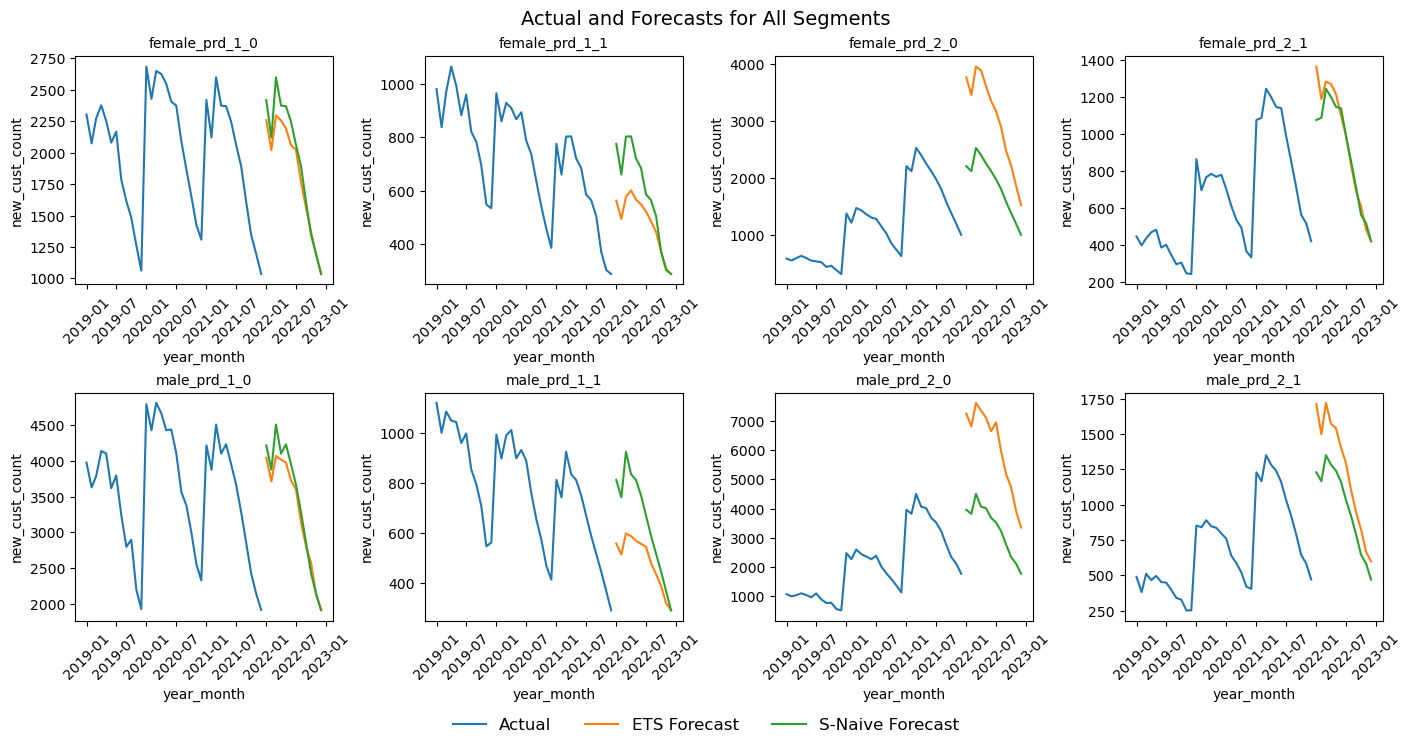

In [68]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7), constrained_layout=True)
axes = axes.flatten()

for i, seg in enumerate(segments):
    ax = axes[i]
    sdf = df_forecast.loc[df_forecast["segment"] == seg].sort_values("year_month").tail(36+n_periods)

    ax.plot(sdf["year_month"], sdf["new_cust_count"], label="Actual", color="tab:blue")
    ax.plot(sdf["year_month"], sdf["new_cust_count_ets"], label="ETS Forecast", color="tab:orange")
    ax.plot(sdf["year_month"], sdf["new_cust_count_snaive"], label="S-Naive Forecast", color="tab:green")
    ax.set_title(seg,fontsize = 10)
    ax.set_xlabel("year_month")
    ax.set_ylabel("new_cust_count")
    ax.tick_params(axis="x", rotation=45)


# Single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="lower center",ncol=3,fontsize=12,frameon=False,bbox_to_anchor=(0.5, -0.06)  
)
fig.suptitle("Actual and Forecasts for All Segments", fontsize=14)
plt.show()

Based on visual inspection, both models produce reasonable forecasts given the scope of this notebook. If the slope changes, the S-Naive model will not capture it (e.g., female_prd_2_2). By contrast, the ETS model may over-extend recent trends (e.g., male_prd_1_1).

As discussed above, growth in product 2 has been rapid. There is a possibility that unobserved drivers (e.g. campaigns) contributed to this acceleration. If these drivers cease in 2022, growth could flatten (or reverse). To guardrail against such a scenario, I combine ETS and S-Naive forecasts, thereby creating a conservative forecast bracket. The chosen weights (below) reflect my belief that ETS is more credible.

In a real business scenario, I would employ a cross-validation strategy to improve robust & accuracy as follows:

    1. Split the data into a modelling and test set
    2. For each validation fold, I further split the modeling data into training and validation sets.
    3. Tune hyperparameters of several models (e.g. ETS, ARIMA, Prophet) based on the training data
    4. Use the validation data to compute out-of-sample forecast performance for each model. Assign ensemble weights proportional to forecast the performance.
    5. Average weights across folds to obtain the final ensemble weights
    6. Produce forecast and benchmark those against the test set to get an idea of the true out-of-sample accuracy.

In [69]:
weight_ets = 2/3

In [70]:
df_forecast['adds_ensemble_fc'] = weight_ets * df_forecast.new_cust_count_ets + (1-weight_ets) * df_forecast.new_cust_count_snaive

## Churn Forecast

In general, there are two different approaches that allow us to forecast churn. A hazard model predicts the probability of churn on a customer level and allows us to take a customer’s tenure and previous touchpoints (e.g., support inquiries) into account. Such a model is often more accurate and allows driver-level interpretation (e.g. lags of inquiries); it can help with causal inference (likely requires additional assumption, checks etc.). For example, we might find that a customer’s churn probability decreases by ~50% after the first year.

On the other hand, we can employ a time-series approach that forecasts the churn rate per segment, i.e., predicts aggregated cancellations. Given the short time horizon (3 months), the objective, and the time constraint, I proceed with a time-series approach.

**Descriptive Analysis**

Let us take a look at the how the churn rate per segment evolved over time.

In [71]:
df_churn = pd.merge(df_cust_prod[['customer_id','year_month','year_month_cancel','lifetime_days','active_cust']], 
                    df_adds[['customer_id','product','gender','pre_signup_contact']],
                    on = 'customer_id', how = 'left')

In [72]:
df_churn['segment'] = df_churn["gender"].astype(str) + "_" +df_churn["product"].astype(str) + "_" + df_churn["pre_signup_contact"].astype(str)

In [73]:
signups = df_churn.groupby(["year_month",'segment'])["customer_id"].nunique().rename("signups")

In [74]:
cancels = df_churn.dropna(subset=["year_month_cancel"]).groupby(["year_month_cancel","segment"])["customer_id"].nunique().rename("cancellations").rename_axis(index={"year_month_cancel": "year_month"})  

In [75]:
monthly_churns = pd.concat([signups, cancels], axis=1).fillna(0).reset_index().sort_values(by = ['segment','year_month'])

In [76]:
monthly_churns["active_end"] = monthly_churns.groupby('segment')["signups"].cumsum() - monthly_churns.groupby('segment')["cancellations"].cumsum()

In [77]:
monthly_churns["active_start"] = monthly_churns.groupby("segment")["active_end"].shift(1)

In [78]:
monthly_churns["churn_rate"] = monthly_churns["cancellations"] / monthly_churns["active_start"].replace(0, np.nan) # I link the cancellations to the customer base from the previous month # I link the cancellations to the customer base from the previous month

In [79]:
churn_plots = monthly_churns.query("year_month >'2017-01-01'").copy()

In [80]:
churn_plots['prod'] = churn_plots.segment.str.extract(r'(?i)prd_(\d+)') 

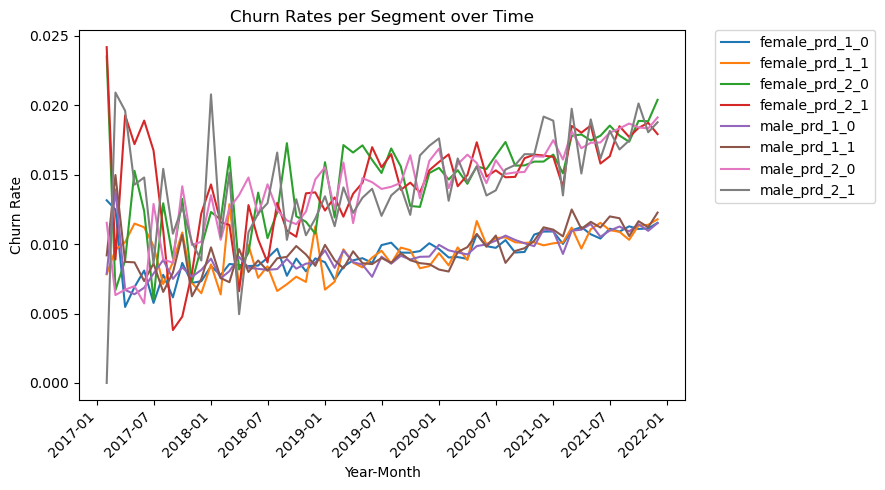

In [81]:
fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=churn_plots,x="year_month",y="churn_rate",hue="segment", ax=ax)

ax.set_title("Churn Rates per Segment over Time")
ax.set_xlabel("Year-Month")
ax.set_ylabel("Churn Rate")


locator = mdates.MonthLocator(bymonth=[1, 7])  
formatter = mdates.DateFormatter("%Y-%m")
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor=(1.05, 1),loc="upper left",  borderaxespad=0)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

We observe that churn rates initially fluctuate substantially which might be cause by the small customer base and stabilizes thereafter with a clear upward trend. As expected, the rates for product 1 (annual) are consistently smaller. Product 2 grows faster, but churn rates are higher.

**Forecast Model**

Contrary to the Adds growth, there is a clear upward trend and hence, a S-Naive is unlikely to be a useful conservative as a guardrail. In order to "get a second opinion", I add an ARIMA model.

The series seems stable from 2019 onwards so I do not transform the data. Without a time constraint, I would double check that

In [82]:
df_forecast_churn = pd.merge(future_dates, groups, how='cross')
for ts_id in segments: 
    
    y = monthly_churns[monthly_churns["segment"] == ts_id]['churn_rate'].to_numpy()
    y = y[-36:]
    # ETS
    pred_ets,sigma2 = ets_model(y = y, n_periods = n_periods) 
    df_forecast_churn.loc[df_forecast_churn["segment"] == ts_id, "churn_rate_ets"] = pred_ets

    # ARIMA 
    model_arima = pmd.auto_arima(y = y, seasonal = True,  max_p = 2, max_q = 2, max_d = 1, m = 12, max_P = 1, max_Q = 1, max_D = 1) 
    pred_arima = model_arima.predict(n_periods = n_periods)
    df_forecast_churn.loc[df_forecast_churn["segment"] == ts_id, "churn_rate_arima"] = pred_arima

C:\Users\flel8\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [83]:
df_forecast_churn = pd.concat([monthly_churns, df_forecast_churn], axis=0)

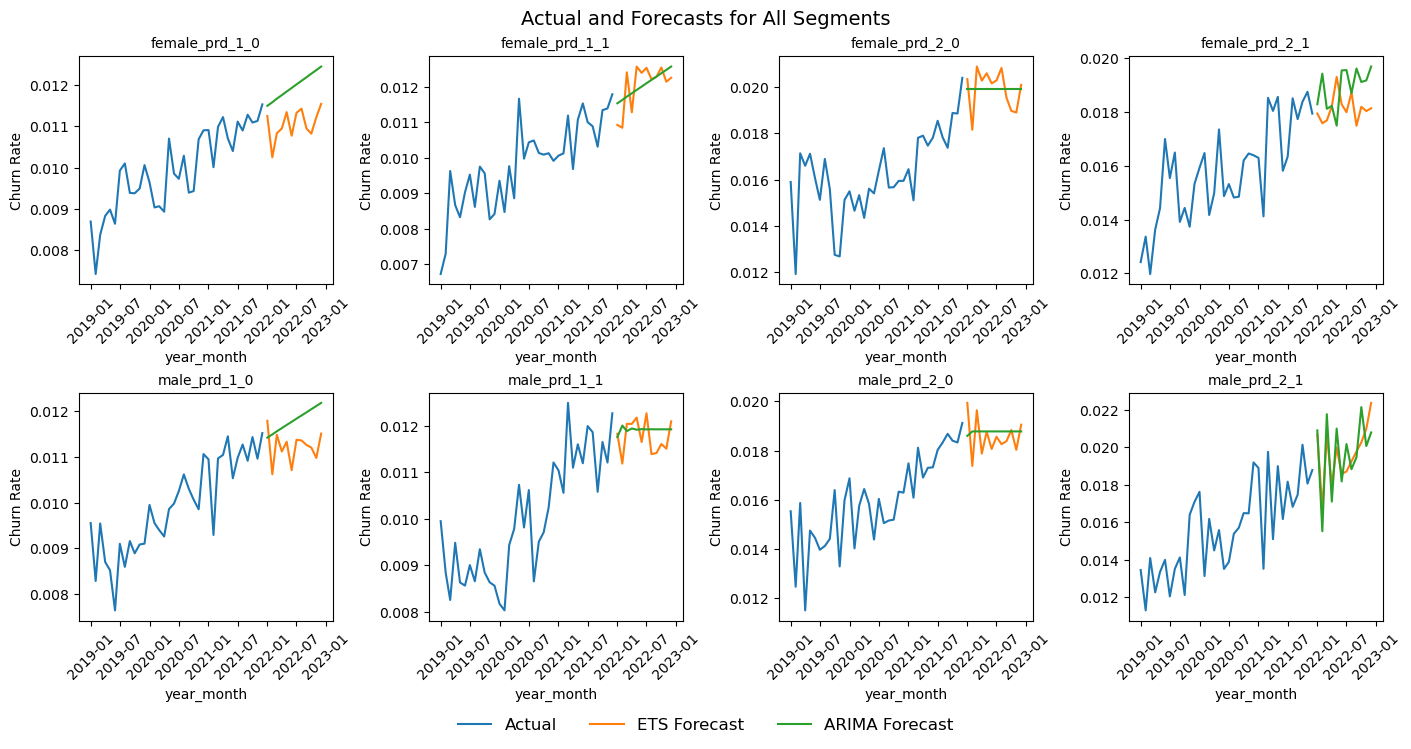

In [84]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7), constrained_layout=True)
axes = axes.flatten()

for i, seg in enumerate(segments):
    ax = axes[i]
    sdf = df_forecast_churn.loc[df_forecast_churn["segment"] == seg].sort_values("year_month").tail(36+n_periods)

    ax.plot(sdf["year_month"], sdf["churn_rate"], label="Actual", color="tab:blue")
    ax.plot(sdf["year_month"], sdf["churn_rate_ets"], label="ETS Forecast", color="tab:orange")
    ax.plot(sdf["year_month"], sdf["churn_rate_arima"], label="ARIMA Forecast", color="tab:green")
    ax.set_title(seg,fontsize = 10)
    ax.set_xlabel("year_month")
    ax.set_ylabel("Churn Rate")
    ax.tick_params(axis="x", rotation=45)


# Single legend for the whole figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="lower center",ncol=3,fontsize=12,frameon=False,bbox_to_anchor=(0.5, -0.06)  
)
fig.suptitle("Actual and Forecasts for All Segments", fontsize=14)
plt.show()

Based on a visual inspection, the ETS models seems to track the seasonal levels and are more conservative in general. ARIMA models place more weight on the recent trends. Weights are arbitrarily chosen to be equal 

In [85]:
weights_ets = 1/2

In [86]:
df_forecast_churn['churn_ensemble_fc'] = weights_ets * df_forecast_churn.churn_rate_ets + (1-weights_ets) * df_forecast_churn.churn_rate_arima

# Revenue Projection

**Active Customer on January 1 2022:**

In [87]:
active_cust = df_adds.query('active_cust == 1').groupby(['product','gender','pre_signup_contact']).agg(active_cust=("customer_id", "nunique")).reset_index()

In [88]:
active_cust['segment'] = active_cust["gender"].astype(str) + "_" +active_cust["product"].astype(str) + "_" + active_cust["pre_signup_contact"].astype(str)

In [89]:
active_cust['year_month'] = pd.to_datetime("2021-12-01")

**Adds & Chruns**

In [90]:
new_custs = df_forecast.query('"2022-04-01" > year_month >= "2022-01-01"')[['year_month','segment','adds_ensemble_fc']].copy()

In [91]:
churns = df_forecast_churn.query('"2022-04-01" > year_month >= "2022-01-01"')[['year_month','segment','churn_ensemble_fc']].copy()

In [92]:
dynamics = pd.merge(new_custs,churns, on = ['year_month','segment'], how = 'inner')

**Projected Customers**

In [93]:
projection = pd.merge(dynamics,active_cust[["segment","active_cust",'product','year_month']], on=["segment",'year_month'], how="outer")

In [94]:
projection.sort_values(by  = ['segment','year_month'],inplace = True)

In [95]:
for segment in segments:
    seg = projection[projection["segment"] == segment]
    actives = seg["active_cust"].iloc[0]

    for i, row in seg.iloc[1:].iterrows():
        actives = actives * (1 - row["churn_ensemble_fc"]) + row["adds_ensemble_fc"] # The churn rate 
        projection.at[i, "active_cust_proj"] = actives

In [96]:
projection["product"] = projection.groupby("segment")["product"].ffill()

In [97]:
projection_agg = projection.query('year_month > "2021-12-01"').groupby(['year_month','product']).agg(total_proj_cust = ('active_cust_proj','sum')).reset_index()

In [98]:
projection_agg

,year_month,product,total_proj_cust
0,2022-01-01,prd_1,"260,710.04"
1,2022-01-01,prd_2,"149,952.20"
2,2022-02-01,prd_1,"264,778.55"
3,2022-02-01,prd_2,"158,603.97"
4,2022-03-01,prd_1,"269,693.92"
5,2022-03-01,prd_2,"168,414.05"


The above table gives us the number of projected customers based on the active customer base at the end of 2021.

For the sake of simplicity, I assume that customers who churn stop bringing in revenue from the following month onward. In other words, only customers active at the start of a month are counted as revenue-generating in that month. To make revenue comparable across products, I divide the annual subscription fee evenly by 12 so that each active customer contributes a monthly amount. I do not explicitly model notice periods; in reality, annual subscribers who cancel typically continue generating revenue until the end of their term.

**Revenue Projection**

In [99]:
results = pd.merge(projection_agg,df_prod,left_on = 'product',right_on = 'product_id',how = 'left')

In [100]:
results['revenue'] =  results["total_proj_cust"] * (results["price"] / results["billing_cycle"])

In [101]:
results_mrr  = results.groupby("year_month")["revenue"].sum().reset_index()

In [102]:
results_mrr

,year_month,revenue
0,2022-01-01,"44,815,029.20"
1,2022-02-01,"46,303,351.66"
2,2022-03-01,"48,021,147.30"


**Growth Rates**

In [103]:
# Revenue in Dec 2021:
mrr_21_12 = (len(df_cust_prod.query('active_cust == 1 & product =="prd_1"')) * 100) + (len(df_cust_prod.query('active_cust == 1 & product =="prd_2"')) * 125)

In [104]:
m = pd.Timestamp("2021-01-01")
mask =  (df_cust_prod['signup_date'] <= m) & (df_cust_prod['year_month_cancel'].isna() | (df_cust_prod['year_month_cancel'] >= m))
mrr_21_01 = len(df_cust_prod[mask & (df_cust_prod['product'] == "prd_1")]) * 100  + len(df_cust_prod[mask & (df_cust_prod['product'] == "prd_2")]) * 125

In [105]:
mrr_22_01 = results_mrr.iloc[0,1]

In [106]:
mom = (mrr_22_01 - mrr_21_12) / mrr_21_12 

In [107]:
yoy = (mrr_22_01 - mrr_21_01) / mrr_21_01 

In [108]:
print(f"In January 2022, revenue is predicted to increased by {mom:.2%} compared to December "f"and by {yoy:.2%} year-over-year.")

In January 2022, revenue is predicted to increased by 3.84% compared to December and by 45.17% year-over-year.


# Appendix

Instead of forecasting Adds & Churns, we can also forecast active customers (per segment).

*Active Customer Count Dataframe*

In [109]:
df_cust_prod.head(1)

,customer_id,product,signup_date_time,cancel_date_time,signup_date,year_month,year_month_cancel,active_cust,lifetime_days
0,C2448,prd_1,2017-01-01 10:35:09,NaT,2017-01-01,2017-01-01,NaT,1,"1,825.00"


In [110]:
first_month = df_cust_prod['year_month'].min()
last_month  = df_cust_prod['year_month'].max()
all_months = pd.date_range(first_month, last_month, freq='MS')

In [111]:
keys = ['product','pre_signup_contact','gender']

In [112]:
df_actives  = []
for m in all_months:
    mask = (df_adds['signup_date'] <= m) & (
        df_adds['year_month_cancel'].isna() | (df_adds['year_month_cancel'] >= m)
    )

    counts = (
        df_adds.loc[mask]
          .groupby(keys)['customer_id']
          .nunique()                    
          .rename('active_customer')
          .reset_index()
    )
    counts['year_month'] = m
    df_actives.append(counts)

df_cum = pd.concat(df_actives, ignore_index=True).sort_values(keys + ['year_month'])

In [113]:
df_cum['segment'] =  df_cum["gender"].astype(str) + "_" +df_cum["product"].astype(str) + "_" + df_cum["pre_signup_contact"].astype(str)

*Descriptive Plots & Forecasts*

In [114]:
df_temp_p = df_cum.groupby(['product','year_month']).agg(cum_active_cust=('active_customer', 'sum')).reset_index()
df_temp_g = df_cum.groupby(['gender','year_month']).agg(cum_active_cust=('active_customer', 'sum')).reset_index()
df_temp_s = df_cum.groupby(['pre_signup_contact','year_month']).agg(cum_active_cust=('active_customer', 'sum')).reset_index()

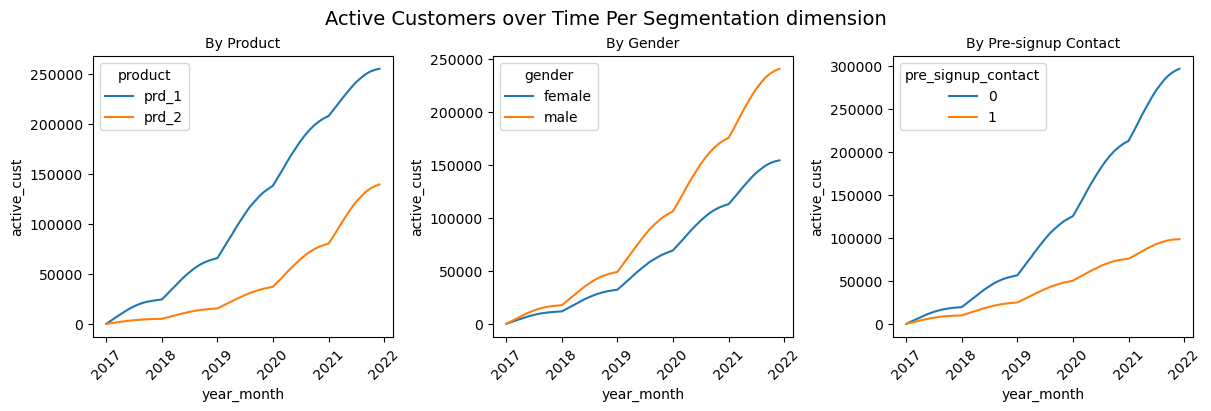

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
axes = axes.flatten()

# By product
sns.lineplot(data=df_temp_p, x="year_month", y="cum_active_cust", hue="product", ax=axes[0])
axes[0].set_title("By Product", fontsize=10)
axes[0].set_xlabel("year_month")
axes[0].set_ylabel("active_cust")
axes[0].tick_params(axis="x", rotation=45)

# By gender
sns.lineplot(data=df_temp_g, x="year_month", y="cum_active_cust", hue="gender", ax=axes[1])
axes[1].set_title("By Gender", fontsize=10)
axes[1].set_xlabel("year_month")
axes[1].set_ylabel("active_cust")
axes[1].tick_params(axis="x", rotation=45)

# By pre-signup contact
sns.lineplot(data=df_temp_s, x="year_month", y="cum_active_cust", hue="pre_signup_contact", ax=axes[2])
axes[2].set_title("By Pre-signup Contact", fontsize=10)
axes[2].set_xlabel("year_month")
axes[2].set_ylabel("active_cust")
axes[2].tick_params(axis="x", rotation=45)

fig.suptitle("Active Customers over Time Per Segmentation dimension", fontsize=14)
plt.show()

In [116]:
df_cum['y'] = np.log(df_cum.active_customer)

In [117]:
df_cum.query('year_month == "2021-12-01"').active_customer.sum()

C:\Users\flel8\AppData\Local\Temp\ipykernel_8332\772920567.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_cum.query('year_month == "2021-12-01"').active_customer.sum()


395193

In [118]:
df_forecast_active = pd.merge(future_dates, groups, how='cross')
for ts_id in segments: 
    
    y = df_cum[df_cum["segment"] == ts_id]['y'].to_numpy()
    y = y[-36:]  
    
    # ETS
    pred_ets,sigma2 = ets_model(y = y, n_periods = n_periods) 
    df_forecast_active.loc[df_forecast_active["segment"] == ts_id, "new_cust_count_ets"] = np.exp(pred_ets + .5 * sigma2) # bias-corrected back transformation

    # SNaive
    sn = NaiveForecaster(strategy="last", sp=12) 
    pred_sn =  sn.fit(np.exp(y)).predict(fh = np.arange(1,n_periods+1))
    df_forecast_active.loc[df_forecast_active["segment"] == ts_id, "new_cust_count_snaive"] = pred_sn

In [119]:
df_forecast_active = pd.concat([df_cum, df_forecast_active], axis=0)

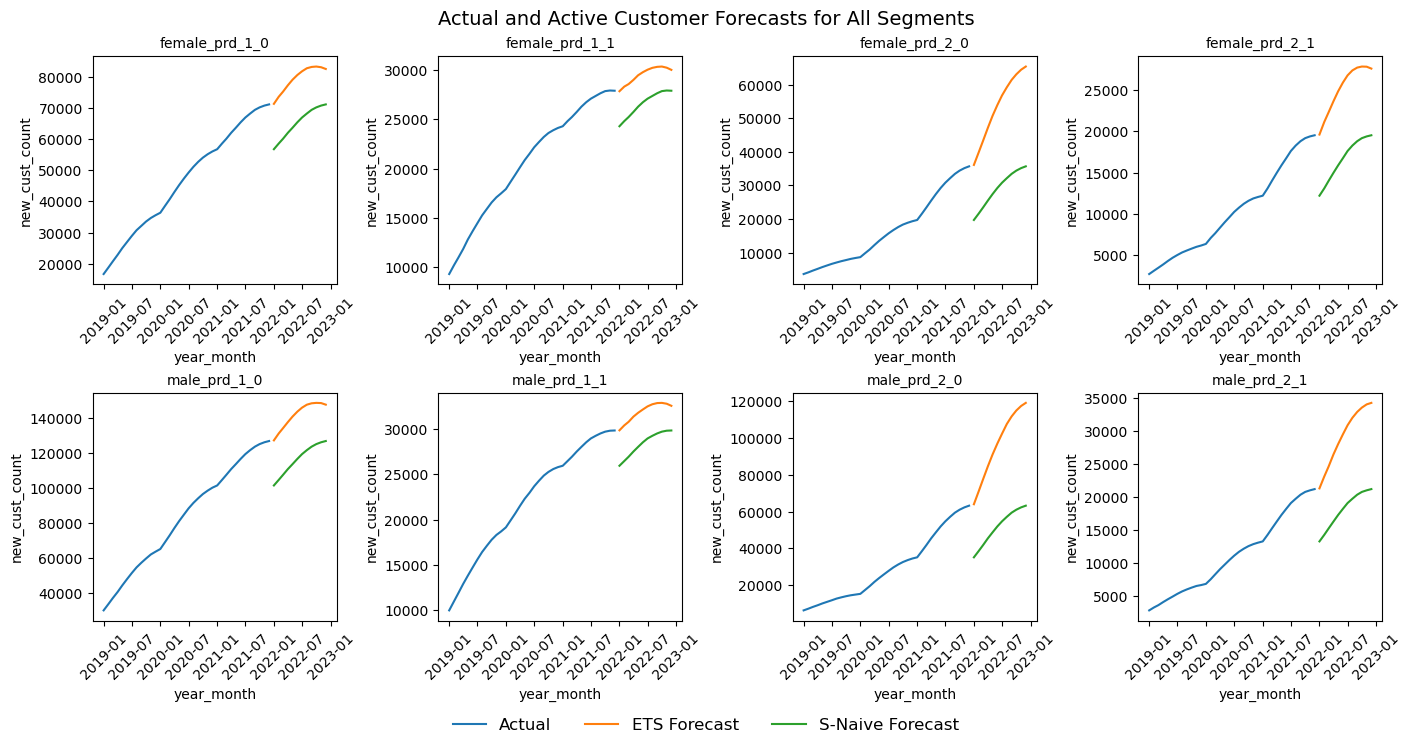

In [120]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7), constrained_layout=True)
axes = axes.flatten()

for i, seg in enumerate(segments):
    ax = axes[i]
    sdf = df_forecast_active.loc[df_forecast_active["segment"] == seg].sort_values("year_month").tail(36+n_periods)

    ax.plot(sdf["year_month"], sdf["active_customer"], label="Actual", color="tab:blue")
    ax.plot(sdf["year_month"], sdf["new_cust_count_ets"], label="ETS Forecast", color="tab:orange")
    ax.plot(sdf["year_month"], sdf["new_cust_count_snaive"], label="S-Naive Forecast", color="tab:green")
    ax.set_title(seg,fontsize = 10)
    ax.set_xlabel("year_month")
    ax.set_ylabel("new_cust_count")
    ax.tick_params(axis="x", rotation=45)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="lower center",ncol=3,fontsize=12,frameon=False,bbox_to_anchor=(0.5, -0.06)  
)
fig.suptitle("Actual and Active Customer Forecasts for All Segments", fontsize=14)
plt.show()

We see that the S-Naive Forecast does not pick up any growth. I will therefore only use the ETS Forecast

In [121]:
df_forecast_active['product']= df_forecast_active.groupby("segment")["product"].ffill()

In [122]:
fc_active = df_forecast_active.query('new_cust_count_ets.notna() & year_month < "2022-04-01"').copy()

In [123]:
fc_active['fc_ensemble'] = 1 * fc_active.new_cust_count_ets 

In [124]:
results_active = fc_active.groupby(['year_month','product'])['fc_ensemble'].sum().reset_index()

In [125]:
results_active = pd.merge(results_active,df_prod,left_on = 'product',right_on = 'product_id',how = 'left')

In [126]:
results_active['revenue'] =  results_active["fc_ensemble"] * (results_active["price"] / results_active["billing_cycle"])

In [127]:
results_active

,year_month,product,fc_ensemble,product_id,name,price,billing_cycle,revenue
0,2022-01-01,prd_1,"256,071.78",prd_1,annual_subscription,1200,12,"25,607,178.00"
1,2022-01-01,prd_2,"141,040.38",prd_2,monthly_subscription,125,1,"17,630,047.06"
2,2022-02-01,prd_1,"263,300.14",prd_1,annual_subscription,1200,12,"26,330,014.33"
3,2022-02-01,prd_2,"155,194.25",prd_2,monthly_subscription,125,1,"19,399,281.69"
4,2022-03-01,prd_1,"268,662.69",prd_1,annual_subscription,1200,12,"26,866,268.92"
5,2022-03-01,prd_2,"167,802.91",prd_2,monthly_subscription,125,1,"20,975,363.63"


In [128]:
results_mrr_active  = results_active.groupby("year_month")["revenue"].sum().reset_index()

In [129]:
results_mrr_active

,year_month,revenue
0,2022-01-01,"43,237,225.06"
1,2022-02-01,"45,729,296.01"
2,2022-03-01,"47,841,632.55"


In [130]:
mrr_22_01_a = results_mrr_active.iloc[0,1]

In [131]:
mom_agg = (mrr_22_01_a - mrr_21_12) / mrr_21_12 

In [132]:
yoy_agg = (mrr_22_01_a - mrr_21_01) / mrr_21_01 

In [133]:
print(f"In January 2022, revenue is predicted to increased by {mom_agg:.2%} compared to December "f"and by {yoy_agg:.2%} year-over-year.")

In January 2022, revenue is predicted to increased by 0.19% compared to December and by 40.06% year-over-year.


In [134]:
print(f"This is a substantially smaller growth compared to the main approach ({mom:.2%} & {yoy:.2%}). ")

This is a substantially smaller growth compared to the main approach (3.84% & 45.17%). 
